# Evaluating the performance of the models produced during 5-fold cross validation

This notebook will reprodue the results of the report that is summarises the work of this repository.

To run this notebook 5 files or folders is needed.

  1) A csv file containing all protein ID's, there target values, lengths and  information about which proteins belong to each fold for cross validation. 
  2) A numpy file just containing the protein ID's 
  3) A file containing the predictions of the SOTA model DeepTMHMM 
  4) A folder containing the 5 trained models from the 5-fold cross validation 
  5) A folder containing 3544 protein encodings as .pt file (NB, 3.35 GB) 


The first 3 mentioned files can be found under the folder 'data' in this repository, and the folder containing the models is called 'models'.

The last folder containing the 3544 protein encodings can be downloaded by using this link https://www.dropbox.com/scl/fo/fldja9rwecmcbgutn13nm/h?rlkey=m1mvj346eq7pgezr5fpxb7818&dl=0

The pathes to the mentioned files/folders can be changed in the cell below and follows the numbering as stated above.

In [ ]:
PATH_1 = '/content/drive/My Drive/PTP_project/data/dataframe_ids_y_len_prot_fold.csv'
PATH_2 = '/content/drive/My Drive/PTP_project/data/ids.npy'
PATH_3 = '/content/drive/My Drive/PTP_project/data/DeepTMHMM.crossval.top.txt'
PATH_4 = '/content/drive/My Drive/PTP_project/models/'
PATH_5 = '/content/drive/My Drive/PTP_project/data/protein_encodings/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from typing import List, Union
import numpy as np
import pandas as pd
import math
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

#Extracting DeepTMHMM's predictions and ID's into a dictionary

In [ ]:
ids_array = np.load(PATH_2)
input_file = PATH_3

labels = {}

# Open the text file for reading
with open(input_file, 'r') as file:
    lines = file.readlines()

# Loop through the lines in the file
for i in range(0, len(lines), 4):  # Process groups of 4 lines at a time
    # Extract ID and prediction from the current group of lines
    ID = lines[i].strip().lstrip('>')   # Remove newline characters
    prediction = lines[i + 3].strip()
    label = lines[i + 2].strip() # Assuming prediction is in the 4th line of each group
    if ID in ids_array:
        # Store the ID-prediction pair in the dictionary
        labels[ID] = [prediction, label]

#Loading functions that the biological accuracy function is dependent on

We are working with a tailored accuracy function, the biological accuracy function, as specified in the report. This function is dependend on the following four functions.

In [ ]:
def label_list_to_topology(labels: Union[List[int], torch.Tensor]) -> List[torch.Tensor]:
    """
    Converts a list of per-position labels to a topology representation.
    This maps every sequence to list of where each new symbol start (the topology), e.g. AAABBBBCCC -> [(0,A),(3, B)(7,C)]

    Parameters
    ----------
    labels : list or torch.Tensor of ints
        List of labels.

    Returns
    -------
    list of torch.Tensor
        List of tensors that represents the topology.
    """

    if isinstance(labels, list):
        labels = torch.LongTensor(labels)

    if isinstance(labels, torch.Tensor):
        zero_tensor = torch.LongTensor([0])
        if labels.is_cuda:
            zero_tensor = zero_tensor.cuda()

        unique, count = torch.unique_consecutive(labels, return_counts=True)
        top_list = [torch.cat((zero_tensor, labels[0:1]))]
        prev_count = 0
        i = 0
        for _ in unique.split(1):
            if i == 0:
                i += 1
                continue
            prev_count += count[i - 1]
            top_list.append(torch.cat((prev_count.view(1), unique[i].view(1))))
            i += 1
        return top_list

In [ ]:
def is_topologies_equal(topology_a, topology_b, minimum_seqment_overlap=5):
    """
    Checks whether two topologies are equal.
    E.g. [(0,A),(3, B)(7,C)]  is the same as [(0,A),(4, B)(7,C)]
    But not the same as [(0,A),(3, C)(7,B)]

    Parameters
    ----------
    topology_a : list of torch.Tensor
        First topology. See label_list_to_topology.
    topology_b : list of torch.Tensor
        Second topology. See label_list_to_topology.
    minimum_seqment_overlap : int
        Minimum overlap between two segments to be considered equal.

    Returns
    -------
    bool
        True if topologies are equal, False otherwise.
    """

    if isinstance(topology_a[0], torch.Tensor):
        topology_a = list([a.cpu().numpy() for a in topology_a])
    if isinstance(topology_b[0], torch.Tensor):
        topology_b = list([b.cpu().numpy() for b in topology_b])
    if len(topology_a) != len(topology_b):
        return False
    for idx, (_position_a, label_a) in enumerate(topology_a):
        if label_a != topology_b[idx][1]:
            if (label_a in (1,2) and topology_b[idx][1] in (1,2)): # assume O == P
                continue
            else:
                return False
        if label_a in (3, 4, 5):
            overlap_segment_start = max(topology_a[idx][0], topology_b[idx][0])
            overlap_segment_end = min(topology_a[idx + 1][0], topology_b[idx + 1][0])
            if label_a == 5:
                # Set minimum segment overlap to 3 for Beta regions
                minimum_seqment_overlap = 3
            if overlap_segment_end - overlap_segment_start < minimum_seqment_overlap:
                return False
    return True

In [ ]:
def calculate_acc(correct, total):
    total = total.float()
    correct = correct.float()
    if total == 0.0:
        return 1
    return correct / total

In [ ]:
def type_from_labels(label):
    """
    Function that determines the protein type from labels

    Dimension of each label:
    (len_of_longenst_protein_in_batch)

    # Residue class
    0 = inside cell/cytosol (I)
    1 = Outside cell/lumen of ER/Golgi/lysosomes (O)
    2 = beta membrane (B)
    3 = signal peptide (S)
    4 = alpha membrane (M)
    5 = periplasm (P)

    B in the label sequence -> beta
    I only -> globular
    Both S and M -> SP + alpha(TM)
    M -> alpha(TM)
    S -> signal peptide

    # Protein type class
    0 = TM
    1 = SP + TM
    2 = SP
    3 = GLOBULAR
    4 = BETA
    """

    if 2 in label:
        ptype = 4

    elif all(element == 0 for element in label):
        ptype = 3

    elif 3 in label and 4 in label:
        ptype = 1

    elif 3 in label:
       ptype = 2

    elif 4 in label:
        ptype = 0

    elif all(x == 0 or x == -1 for x in label):
        ptype = 3

    else:
        ptype = None

    return ptype

# Loading the biological accuracy function

In [ ]:
def bio_acc_test(output, target):
    """
    Functions that calculates a biological accuracy based on both
    topology and protein type predictions
    """

    confusion_matrix = torch.zeros((6,6),dtype = torch.int64)


    for i in range(len(output)):

        # Get topology
        output_topology = label_list_to_topology(output[i])
        target_topology = label_list_to_topology(target[i])

        # Get protein type
        output_type = type_from_labels(output[i])
        target_type = type_from_labels(target[i])


        # Check if topologies match
        prediction_topology_match = is_topologies_equal(output_topology, target_topology, 5)

        if target_type == output_type:
            # if we guessed the type right for SP+GLOB or GLOB,
            # count the topology as correct
            if target_type == 2 or target_type == 3 or prediction_topology_match:
                confusion_matrix[target_type][5] += 1
            else:
                confusion_matrix[target_type][output_type] += 1

        else:
            confusion_matrix[target_type][output_type] += 1

    # Calculate individual class accuracy for protein type prediction
    tm_type_acc = float(calculate_acc(confusion_matrix[0][0] + confusion_matrix[0][5], confusion_matrix[0].sum()))
    tm_sp_type_acc = float(calculate_acc(confusion_matrix[1][1] + confusion_matrix[1][5], confusion_matrix[1].sum()))
    sp_type_acc = float(calculate_acc(confusion_matrix[2][2] + confusion_matrix[2][5], confusion_matrix[2].sum()))
    glob_type_acc = float(calculate_acc(confusion_matrix[3][3] + confusion_matrix[3][5], confusion_matrix[3].sum()))
    beta_type_acc = float(calculate_acc(confusion_matrix[4][4] + confusion_matrix[4][5], confusion_matrix[4].sum()))

    # Calculate individual class accuracy for protein topology prediction
    tm_accuracy = float(calculate_acc(confusion_matrix[0][5], confusion_matrix[0].sum()))
    sptm_accuracy = float(calculate_acc(confusion_matrix[1][5], confusion_matrix[1].sum()))
    sp_accuracy = float(calculate_acc(confusion_matrix[2][5], confusion_matrix[2].sum()))
    glob_accuracy = float(calculate_acc(confusion_matrix[3][5], confusion_matrix[3].sum()))
    beta_accuracy = float(calculate_acc(confusion_matrix[4][5], confusion_matrix[4].sum()))

    # Calculate average accuracy for protein type prediction
    type_correct_ratio = (tm_type_acc + tm_sp_type_acc + sp_type_acc + glob_type_acc + beta_type_acc) / 5

    # New naming
    #type_accuracy = (tm_type_acc + tm_sp_type_acc + sp_type_acc + glob_type_acc + beta_type_acc) / 5

    # Calculate average accuracy for protein topology prediction
    topology_correct_ratio = (tm_accuracy + sptm_accuracy + sp_accuracy + glob_accuracy + beta_accuracy) / 5

    # Combined accuracy score for topology and type prediction

    total_accuracy = (type_correct_ratio + topology_correct_ratio) / 2

    return confusion_matrix, type_correct_ratio, tm_type_acc, tm_sp_type_acc, sp_type_acc, glob_type_acc, beta_type_acc, tm_accuracy, sptm_accuracy, sp_accuracy, glob_accuracy, beta_accuracy

# Extract all DeepTMHMM's predictions and targets in seperate lists ready for input to the biological accuracy function

As we want to compare our results with the SOTA model DeepTMHMM, we evaluate their predictions using the biological accuracy function

In [ ]:
predictions = []
targets = []
for value in labels.values():
    # Remane residues in ground truth
    value[0] = value[0].replace('I', '0')
    value[0] = value[0].replace('O', '1')
    value[0] = value[0].replace('P', '2')
    value[0] = value[0].replace('S', '3')
    value[0] = value[0].replace('M', '4')
    value[0] = value[0].replace('B', '5')
    # Remane residues in prediction
    value[1] = value[1].replace('I', '0')
    value[1] = value[1].replace('O', '1')
    value[1] = value[1].replace('P', '2')
    value[1] = value[1].replace('S', '3')
    value[1] = value[1].replace('M', '4')
    value[1] = value[1].replace('B', '5')

    targets.append(value[1])
    predictions.append(value[0])

for i in range(len(predictions)):
    predictions[i] = [int(x) for x in predictions[i]]
    targets[i] = [int(x) for x in targets[i]]

In [ ]:
confusion_matrix_1, type_correct_ratio_1, tm_type_acc_1, tm_sp_type_acc_1, sp_type_acc_1, glob_type_acc_1, beta_type_acc_1, tm_accuracy_1, sptm_accuracy_1, sp_accuracy_1, glob_accuracy_1, beta_accuracy_1 = bio_acc_test(predictions, targets)

In [ ]:
print(f'DeepTMHMM accuracy results: \nAlpha TM type: \t \t {tm_type_acc_1}, Alpha TM topology: \t {tm_accuracy_1}\nAlpha TM+SP type: \t {tm_sp_type_acc_1}, Alpha TM+SP topology: \t {sptm_accuracy_1}\nSP+Globular type: \t {sp_type_acc_1}, SP+Globular topology: \t {sp_accuracy_1}\nGlobular type: \t \t {glob_type_acc_1}, Globular topology: \t {glob_accuracy_1}\nBeta type: \t \t {beta_type_acc_1},\t\t\t Beta topology: \t {beta_accuracy_1}')

DeepTMHMM accuracy results: 
Alpha TM type: 	 	 0.9608355164527893, Alpha TM topology: 	 0.8355091214179993
Alpha TM+SP type: 	 0.970588207244873, Alpha TM+SP topology: 	 0.9215686321258545
SP+Globular type: 	 0.9482071995735168, SP+Globular topology: 	 0.9462151527404785
Globular type: 	 	 0.9661432504653931, Globular topology: 	 0.9607458114624023
Beta type: 	 	 1.0,			 Beta topology: 	 0.8125


# Loading in functions for required for loading the data

To load in our data, we need to load in the encodings and pad to the longest sequence in the batch. This is done using the suboptimal data loader function create_batches(). As mentioned in the report, this will be changed for future work to make the code more computationally efficient.

In [ ]:
def create_batches(data_set, batch_size, X_path):

    # Sorting the sequences by length
    sorted_df = data_set.sort_values('len_prot')

    # Calculating the number of batches
    n_batches = math.ceil(len(data_set) / batch_size)

    # Initiating the result arrays
    batches_X, batches_y, batches_len = [], [], []

    # Creating the batches
    for batch in range(n_batches):

        X_batch = []
        y_batch = []
        max_len = []

        # Calculate the start and end indices for the batch
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        # Finding the longest protein in the batch
        max_len = max(sorted_df[start_idx:end_idx]['len_prot'].values)

        # Loading in the relevant X.pt files in the order of the ids of the batch
        ids_batch = sorted_df[start_idx:end_idx]['ids'].values

        for i in range(len(ids_batch)):

            # Load ESM-IF1 encoding
            ESM_encoding = torch.load(f'{X_path}{ids_batch[i]}.pt')

            # 0 pad so all proteins in the batch have the same length
            pad = nn.ConstantPad2d((0,0,0,(max_len - ESM_encoding.size(0))), 0)
            tmp_x = pad(ESM_encoding)
            X_batch.append(tmp_x)

        # Turn into tensors and collect each batch in a list
        X_batch = torch.stack(X_batch, dim=0)
        batches_X.append(X_batch)

        # Define labels from the df that belongs to the batch
        y_batch_string = sorted_df[start_idx:end_idx]['y'].values

        # -1 pad all labels
        for i in range(len(y_batch_string)):
            # Convert string to a list of integers
            int_list = [int(x) for x in y_batch_string[i]]
            padded_list = int_list + [-1] * (max_len - len(int_list))
            y_batch.append(padded_list)

        # Turn into tensors and collect each batch in a list
        y_batch = torch.tensor(y_batch, dtype=torch.float)
        batches_y.append(y_batch)

        # Saving the size of the batch
        batches_len.append(len(ids_batch))

    return batches_X, batches_y, batches_len

In [ ]:
def create_train_val_test(train_folds, val_fold, test_fold, path):
    df = pd.read_csv(path)

    # Training set
    train_set = df[df['fold'].isin(train_folds)]

    # Validation set
    val_set = df[df.fold == val_fold]

    # Test setv
    test_set = df[df.fold == test_fold]

    return train_set, val_set, test_set

# Load in Model architecture used for training

In [ ]:
class Model4(nn.Module):
    def __init__(self, input_size=512, hidden_size=64, num_classes=6, dropout_prob=0.5):
        super(Model4, self).__init__()

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)

        # Dense layers with dropout
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM, so multiply hidden_size by 2
        self.activation = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM layer
        lstm_output, _ = self.lstm(x)

        # Feedforward through dense layers
        x = self.fc1(lstm_output)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = Model4()

# Loading in the our test data and our 5 trained models from 5-fold cross validation

NB as a consequence of the suboptimal data loader function and the many big .pt encoding files, this cell takes ~ 20-30 min. to run

In [ ]:
predictions = []
targets = []

splits = [([0, 1, 2], 3, 4),
          ([1, 2, 3], 4, 0),
          ([2, 3, 4], 0, 1),
          ([3, 4, 0], 1, 2),
          ([4, 0, 1], 2, 3)]


for i in range(len(splits)):

    test_predictions = []

    # Fetch test set
    _, _, test_set = create_train_val_test(*splits[i], PATH_1)

    # split test set into batches
    batches_X_test, batches_y_test, _ = create_batches(test_set, 30, PATH_5) # CHANGE PATH HERE TO THE FOLDER CONTAINING THE ENCODINGS

    # Load in trained model cooresponding to the current split
    model.load_state_dict(torch.load(f'{PATH_4}model.{i+1}.pt'))

    # Set model to evaluate mode
    model.eval()

    # Save predictions for all proteins in all batches
    for i in range(len(batches_X_test)):
        output = model(batches_X_test[i])
        softmax_output = F.softmax(output, dim = 2)
        prediction = softmax_output.argmax(axis = 2)
        test_predictions.append(prediction)

    # Shorten predictions and target values to original length without -1 padding
    for i in range(len(test_predictions)):
        for j in range(len(test_predictions[i])):
            if (batches_y_test[i][j] == -1).any():
                predictions.append(test_predictions[i][j][0:(batches_y_test[i][j] == -1).nonzero()[0].item()])
                targets.append(batches_y_test[i][j][0:(batches_y_test[i][j] == -1).nonzero()[0].item()])
            else:
                predictions.append(test_predictions[i][j])
                targets.append(batches_y_test[i][j])


In [ ]:
confusion_matrix, type_correct_ratio, tm_type_acc, tm_sp_type_acc, sp_type_acc, glob_type_acc, beta_type_acc, tm_accuracy, sptm_accuracy, sp_accuracy, glob_accuracy, beta_accuracy = bio_acc_test(predictions, targets)

In [ ]:
print(f'Our accuracy results: \nAlpha TM type: \t \t {tm_type_acc}, Alpha TM topology: \t {tm_accuracy}\nAlpha TM+SP type: \t {tm_sp_type_acc}, Alpha TM+SP topology: \t {sptm_accuracy}\nSP+Globular type: \t {sp_type_acc}, SP+Globular topology: \t {sp_accuracy}\nGlobular type: \t \t {glob_type_acc}, Globular topology: \t {glob_accuracy}\nBeta type: \t \t {beta_type_acc},\t\t\t Beta topology: \t {beta_accuracy}')

Our accuracy results: 
Alpha TM type: 	 	 0.7696078419685364, Alpha TM topology: 	 0.05637254938483238
Alpha TM+SP type: 	 0.7589285969734192, Alpha TM+SP topology: 	 0.1428571492433548
SP+Globular type: 	 0.8626570701599121, SP+Globular topology: 	 0.8411130905151367
Globular type: 	 	 0.8090642094612122, Globular topology: 	 0.7754930853843689
Beta type: 	 	 1.0,			 Beta topology: 	 0.03658536449074745


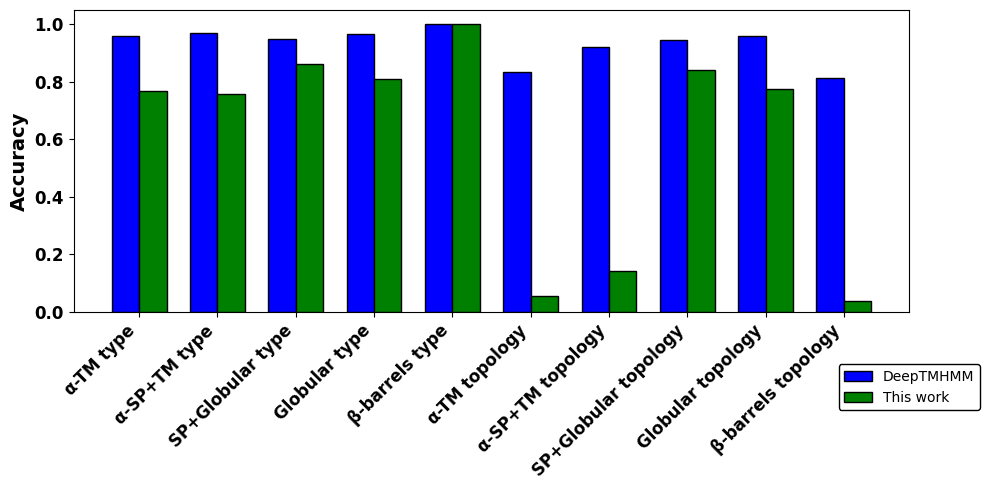

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

categories = ["\u03B1-TM type", "\u03B1-SP+TM type", "SP+Globular type",
    "Globular type", "\u03B2-barrels type", "\u03B1-TM topology", "\u03B1-SP+TM topology",
    "SP+Globular topology", "Globular topology", "\u03B2-barrels topology"
]

# DeepTMHMM performance results
values1 = [
    tm_type_acc_1, tm_sp_type_acc_1, sp_type_acc_1, glob_type_acc_1, beta_type_acc_1, tm_accuracy_1, sptm_accuracy_1, sp_accuracy_1, glob_accuracy_1, beta_accuracy_1
]

# Our performance results
values2 = [tm_type_acc, tm_sp_type_acc, sp_type_acc, glob_type_acc,
    beta_type_acc, tm_accuracy, sptm_accuracy, sp_accuracy, glob_accuracy, beta_accuracy
]


colors1 = 'b'
colors2 = 'g'

x = np.arange(len(categories))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - bar_width/2, values1, bar_width, color=colors1, label='DeepTMHMM', edgecolor='black')
bars2 = ax.bar(x + bar_width/2, values2, bar_width, color=colors2, label='This work', edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)

for label in ax.get_yticklabels():
    label.set_fontweight('bold')

legend = ax.legend(fontsize=10, fancybox=True, framealpha=1, edgecolor='black', loc='upper center', bbox_to_anchor=(1, -0.15))

legend.get_title().set_fontsize(12)
for text in legend.get_texts():
    text.set_fontsize(10)

plt.tight_layout()
plt.show()